In [114]:
# =======================
# Cell 1: Imports
# =======================
import os
import zipfile
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as F
from PIL import Image
import torchvision
from pycocotools.coco import COCO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [115]:
# =======================
# Cell 2: Hyperparameters
# =======================
hyperparams = {
    "learning_rate": 1e-4,
    "batch_size": 8,
    "num_epochs": 15,           # increase for better accuracy
    "num_classes": 91,         # COCO 80 classes + background
    "subset_train": 500,       # small subset for testing
    "subset_val": 500,
    "image_size": 256,
    "optimizer": "Adam"
}

print("🔧 Hyperparameters:")
for k, v in hyperparams.items():
    print(f"{k}: {v}")


🔧 Hyperparameters:
learning_rate: 0.0001
batch_size: 8
num_epochs: 15
num_classes: 91
subset_train: 500
subset_val: 500
image_size: 256
optimizer: Adam


In [116]:
# =======================
# Cell 3: Download COCO Images and Annotations
# =======================
root = "./coco/val2017"
ann_dir = "./coco/annotations"
annFile = os.path.join(ann_dir, "instances_val2017.json")

# Download helper
def download_file(url, save_path):
    if not os.path.exists(save_path):
        print(f"Downloading {url} ...")
        urllib.request.urlretrieve(url, save_path)
        print("Download complete.")

# Download val images
if not os.path.exists(root):
    os.makedirs(root, exist_ok=True)
    url_images = "http://images.cocodataset.org/zips/val2017.zip"
    zip_path = "val2017.zip"
    download_file(url_images, zip_path)
    print("Extracting images...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("./coco")
    os.remove(zip_path)

# Download annotations
if not os.path.exists(annFile):
    os.makedirs(ann_dir, exist_ok=True)
    url_ann = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
    zip_path_ann = "annotations.zip"
    download_file(url_ann, zip_path_ann)
    print("Extracting annotations...")
    with zipfile.ZipFile(zip_path_ann, 'r') as zip_ref:
        zip_ref.extractall("./coco")
    os.remove(zip_path_ann)


In [117]:
# =======================
# Cell 4: Custom COCO Dataset
# =======================
class CocoSegmentationDataset(Dataset):
    def __init__(self, root, annFile, image_size=256, transform=None, subset_size=None):
        self.coco = COCO(annFile)
        self.root = root
        self.transform = transform
        self.img_ids = list(self.coco.imgs.keys())
        if subset_size is not None:
            self.img_ids = self.img_ids[:subset_size]
        self.image_size = image_size

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        img_info = self.coco.loadImgs(img_id)[0]
        path = os.path.join(self.root, img_info['file_name'])
        image = Image.open(path).convert("RGB")

        # Resize image
        if self.transform:
            image = self.transform(image)
        else:
            image = F.to_tensor(F.resize(image, (self.image_size, self.image_size)))

        # Create mask
        mask = np.zeros((self.image_size, self.image_size), dtype=np.uint8)
        for ann in anns:
            m = self.coco.annToMask(ann)
            m_resized = np.array(F.resize(torch.tensor(m, dtype=torch.uint8).unsqueeze(0),
                                          (self.image_size, self.image_size))).squeeze(0)
            mask = np.maximum(mask, m_resized)
        mask_tensor = torch.tensor(mask, dtype=torch.long)

        return image, mask_tensor


In [118]:
# =======================
# Cell 5: Datasets & DataLoaders
# =======================
transform = transforms.Compose([
    transforms.Resize((hyperparams["image_size"], hyperparams["image_size"])),
    transforms.ToTensor(),
])

train_dataset = CocoSegmentationDataset(root=root, annFile=annFile,
                                        image_size=hyperparams["image_size"],
                                        transform=transform,
                                        subset_size=hyperparams["subset_train"])
val_dataset = CocoSegmentationDataset(root=root, annFile=annFile,
                                      image_size=hyperparams["image_size"],
                                      transform=transform,
                                      subset_size=hyperparams["subset_val"])

train_loader = DataLoader(train_dataset, batch_size=hyperparams["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hyperparams["batch_size"], shuffle=False)

coco_api = COCO(annFile)
print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")


loading annotations into memory...
Done (t=0.48s)
creating index...
index created!
loading annotations into memory...
Done (t=0.48s)
creating index...
index created!
loading annotations into memory...
Done (t=0.47s)
creating index...
index created!
Train size: 500, Val size: 500


In [119]:
# =======================
# Cell 6: Model Setup
# =======================
from torchvision.models.segmentation import deeplabv3_resnet50

model = deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, hyperparams["num_classes"], kernel_size=1)
model = model.to(device)


In [120]:
# =======================
# Cell 7: Loss & Optimizer
# =======================
criterion = nn.CrossEntropyLoss()

if hyperparams["optimizer"] == "Adam":
    optimizer = optim.Adam(model.parameters(), lr=hyperparams["learning_rate"])
else:
    optimizer = optim.SGD(model.parameters(), lr=hyperparams["learning_rate"], momentum=0.9)


In [121]:
# =======================
# Cell 8: Training Loop
# =======================
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)["out"]
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

train_model(model, train_loader, criterion, optimizer, hyperparams["num_epochs"])


Epoch [1/15], Loss: 3.2940
Epoch [2/15], Loss: 2.0276
Epoch [3/15], Loss: 1.3245
Epoch [4/15], Loss: 0.8722
Epoch [5/15], Loss: 0.6022
Epoch [6/15], Loss: 0.4345
Epoch [7/15], Loss: 0.3270
Epoch [8/15], Loss: 0.2791
Epoch [9/15], Loss: 0.2277
Epoch [10/15], Loss: 0.1852
Epoch [11/15], Loss: 0.1660
Epoch [12/15], Loss: 0.1433
Epoch [13/15], Loss: 0.1270
Epoch [14/15], Loss: 0.1126
Epoch [15/15], Loss: 0.1097


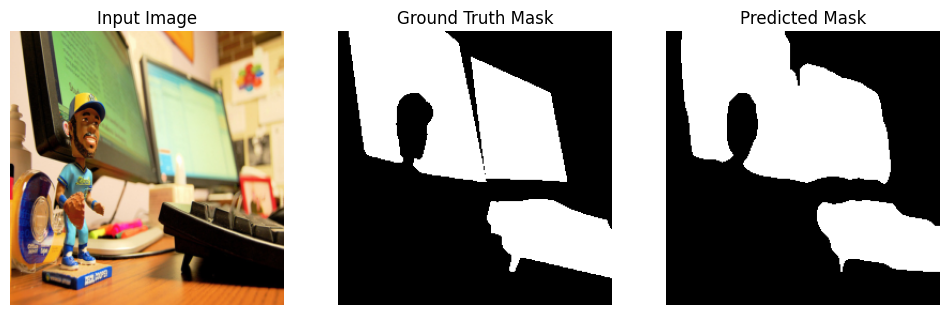

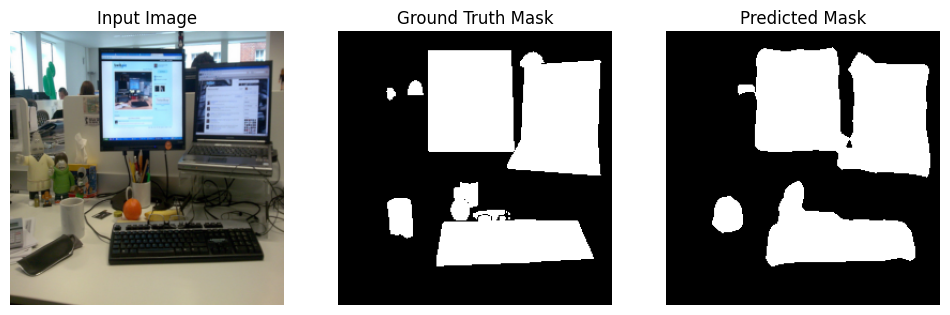

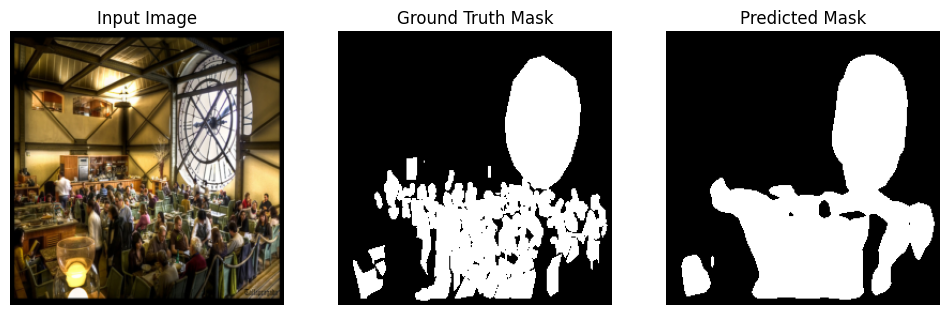

In [122]:
# =======================
# Visualize Final Predictions after Training
# =======================
def visualize_final_predictions(model, data_loader, num_images=3):
    """
    Show the last num_images from the validation loader to demonstrate the final trained predictions.
    """
    model.eval()
    images_so_far = 0
    last_images = []
    last_masks = []

    # Get all images and masks from val_loader
    for images, masks in data_loader:
        last_images = images  # overwrite each batch, last batch will remain
        last_masks = masks

    # Only use the last batch
    with torch.no_grad():
        outputs = model(last_images.to(device))["out"]
        preds = outputs.argmax(1).cpu()

        for i in range(min(num_images, len(last_images))):
            img = last_images[i].permute(1,2,0).numpy()
            img = (img * 255).astype(np.uint8)
            gt_mask = last_masks[i].numpy()
            pred_mask = preds[i].numpy()

            fig, axs = plt.subplots(1,3,figsize=(12,4))
            axs[0].imshow(img); axs[0].set_title("Input Image"); axs[0].axis("off")
            axs[1].imshow(gt_mask, cmap="gray"); axs[1].set_title("Ground Truth Mask"); axs[1].axis("off")
            axs[2].imshow(pred_mask, cmap="gray"); axs[2].set_title("Predicted Mask"); axs[2].axis("off")
            plt.show()

# Call this after training
visualize_final_predictions(model, val_loader, num_images=3)


In [123]:
# =======================
# Updated Cell: Metrics (fixed TypeError)
# =======================
def compute_metrics(model, loader, num_classes):
    model.eval()
    iou_list, dice_list = [], []
    correct, total = 0, 0
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            outputs = model(images)["out"]
            preds = outputs.argmax(1).cpu()
            masks = masks.cpu()

            # Pixel accuracy
            correct += (preds == masks).sum().item()
            total += masks.numel()  # total number of pixels

            # IoU & Dice (for foreground classes)
            for cls in range(1, num_classes):
                intersection = ((preds==cls) & (masks==cls)).sum().item()
                union = ((preds==cls) | (masks==cls)).sum().item()
                pred_sum = (preds==cls).sum().item()
                mask_sum = (masks==cls).sum().item()
                if union > 0:
                    iou_list.append(intersection/union)
                    dice_list.append(2*intersection/(pred_sum + mask_sum))

    pixel_acc = 100 * correct / total
    mean_iou = 100 * np.mean(iou_list) if iou_list else 0
    mean_dice = 100 * np.mean(dice_list) if dice_list else 0

    print(f"Pixel Accuracy: {pixel_acc:.2f}%")
    print(f"Mean IoU: {mean_iou:.2f}%")
    print(f"Mean Dice Score: {mean_dice:.2f}%")

# Call the metrics
compute_metrics(model, val_loader, hyperparams["num_classes"])


Pixel Accuracy: 97.37%
Mean IoU: 91.23%
Mean Dice Score: 95.38%
